[1, 2, 4, 5, 7, 9, 11, 14, 17, 20, 22, 24]
{'time': [1, 2, 4, 5, 7, 9, 11, 14, 17, 20, 22, 24], 'observation': array([[  583.46137547,   246.82433903,   213.82515585,   214.80860026,
          183.27775435,   710.02521528,   376.0158776 ,   336.3074754 ,
          895.32938758,   486.22775838,   400.81551332,   392.94214072],
       [ 2839.71675527,  1183.05320661,   961.85044465,   990.41261177,
          991.55521232,  3482.78372461,  1956.38795871,  1632.0449481 ,
         3931.92045854,  2459.93852571,  2124.89942851,  2187.91494215],
       [ 8107.18318783,  3706.78343625,  3003.57520859,  2942.0398813 ,
         2659.53032645, 11023.73218378,  5390.42259348,  5219.99703665,
        13130.62042913,  7725.09812794,  6880.88972243,  5956.5097744 ]])}
['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']


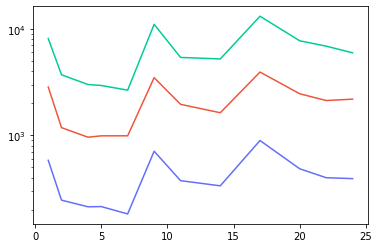

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import myokit
from scipy.integrate import odeint
import pints
import pints.plot
import pints.toy
import math
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.colors
from plotly.validators.scatter.marker import SymbolValidator


raw_symbols = SymbolValidator().values

class Model(pints.ForwardModel):
    
    def __init__(self):
        m = myokit.load_model('ThreeCompartment_IV_Model.mmt') #path for the model file 
        p = myokit.load_protocol('protocol_New.mmt')#path for the protocol file(e.g. dose regimen)
      
        self.simulation = myokit.Simulation(m, p) #define simulation (i.e. run the model via myokit)

    def n_parameters(self):
        return 6 # number of parameters to Fit
    
    def dimension(self):
        # Return the dimension of the parameter vector
        return 6

    def simulate(self, parameters, times):
        Drug_Central = []
        
       #setting up simulation parameters 
        self.simulation.set_state(save_state)
        self.simulation.reset()     
        self.simulation.set_time(0)
        self.simulation.set_constant('AllCompartment.CL', parameters[0]) # define parameter 
        self.simulation.set_constant('AllCompartment.Vc', parameters[1]) # define parameter 
        self.simulation.set_constant('AllCompartment.Qp1', parameters[2]) # define parameter 
        self.simulation.set_constant('AllCompartment.Vp1', parameters[3]) # define parameter 
        self.simulation.set_constant('AllCompartment.Qp2', parameters[4]) # define parameter 
        self.simulation.set_constant('AllCompartment.Vp2', parameters[5]) # define parameter
                                 
        # simulating multiple dose levels
        var_to_log = 'AllCompartment.Drug_Concentration_Central'
        
        DoseAmounts=drug_conc # Define dose level, can move this line to the initialization part 
        for i in range(len(DoseAmounts)):
            self.simulation.reset()  
            self.simulation.set_constant('dose.doseAmount', float(DoseAmounts[i]))
            Output = self.simulation.run(times[-1]+1, log=[var_to_log], log_times = times)
            Drug_Central.append(Output[var_to_log])
        
        return np.array(Drug_Central).T


m = myokit.load_model('ThreeCompartment_IV_Model.mmt') #path for the model file 
p = myokit.load_protocol('protocol_New.mmt') #path for the protocol file(e.g. dose regimen)

ref = myokit.Simulation(m, p) #set up myokit model: input model and protocol 
save_state = ref.state()  #save the original initial state 

# Then create an instance of our new model class
model = Model()

true_params  = [3,5,8,50,2,10] 

# Total  amount of drug dosed: 1mg/kg, 5mg/kg and 15mg/kg dose for mice (unit ng)
TotalDoseLevel= np.array([25000, 125000, 375000])

event_duration = p.events()[0].duration() # Extract duration of the dosing event from the protocol
drug_conc = TotalDoseLevel / event_duration

param_test=[3,5,8,50,2,10] 

times= [1,2,4,5,7,9,11,14,17,20,22,24]

# run a test simulation
values=np.array(model.simulate(param_test ,times))

values = np.array([v + np.random.normal(0, 0.05, v.shape)*v for v in values])
values = np.transpose(values)

synthesized_data = {'time': times,
                 'observation': values}

print(times)                
print(synthesized_data)          
colorlist=plotly.colors.qualitative.Plotly
print(colorlist)
plt.figure()
for i in range(len(drug_conc)):
    drug_conc_i = drug_conc[i]
    plt.semilogy(synthesized_data['time'],synthesized_data['observation'][i,:], color=colorlist[i])


In [2]:
#%% Define error function for fitting 
class ScoreFunction(pints.ErrorMeasure):
    
    def __init__(self, model, times, values, simulate_param):
        # Using sum of squares error for all values
        #
        # model: pints.ForwardModel
        # times: time series to simulate
        # values: multiple series that match model with simulate_param
        # simulate_param: parameters that correspond to each series in values
        super(ScoreFunction, self).__init__()
        
        self._model = model
        self._dimension = self._model.dimension()
        self._times = times
        if len(values) == len(simulate_param):
            self._values = np.asarray(values)
            self._param = np.asarray(simulate_param)
        else:
            raise ValueError('Length of values must be the same as simulate_param')

    def dimension(self):
        """ See :meth:`ErrorMeasure.dimension`. """
        return self._dimension
    
    def n_parameters(self):
        return self._dimension

    def __call__(self, x):
        total = 0
        # go through all simulation parameter (drug concentration)
        for i in range(len(self._param)):
            drug_conc=self._param[i]
            #self._model.simulation.set_constant('dose.doseAmount', self._param[i])
            # simulate the model
            values = self._model.simulate(x, self._times)
            values = np.transpose(values)
            # sum of square error for corresponding values
            # total += np.sum(((values - self._values[i])/self._values[i])**2)

            total += np.sum((np.log10(values) - np.log10(self._values[i]))**2)
            # total += np.sum(((np.log10(values) - np.log10(self._values[i]))/np.log10(self._values[i]))**2)
        return total
# In[21]: Optimization 

InitialEstimate = [3,5,8,50,2,10] 
boundaries =  pints.RectangularBoundaries([2,3,5,20,1,5] , [4,8,20,100,5,20] )

# Add some noise
#values = [v + np.random.normal(0, 0.05*np.max(v), v.shape) for v in values]

# Create self defined score function
score = ScoreFunction(model, times, values, drug_conc)

found_parameters, found_value = pints.optimise(score, InitialEstimate, boundaries=boundaries, method=pints.CMAES)

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_params[k]))



Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      50.31423   0:00.2
1     18     50.31423   0:00.3
2     27     50.31423   0:00.5
3     36     50.31423   0:00.6
20    189    50.31014   0:03.1
40    369    50.31001   0:05.8
60    549    50.30992   0:08.4
80    729    50.30988   0:11.2
100   909    50.30988   0:14.7
120   1089   50.30986   0:17.7
140   1269   50.30986   0:20.6
160   1449   50.30986   0:23.3
180   1629   50.30986   0:26.0
200   1809   50.30986   0:29.4
220   1989   50.30986   0:32.3
240   2169   50.30986   0:35.0
260   2349   50.30986   0:38.1
280   2529   50.30986   0:41.1
300   2709   50.30986   0:44.1
320   2889   50.30986   0:47.1
340   3069   50.30986   0:50.1
360   3249   50.30986   0:53.1
380   3429   50.30986   0:56.0
400   3609   50.30986   0:58.9
420   3789   50.30986   1:01.9
440   3969   50.30986   1:05.1
456   4104   50.30986   1:07

In [3]:

time_test = np.arange(0, 24, 0.1)    

# Plot the results
pop_vs_time_fig = go.Figure()
for i in range(len(drug_conc)):
    plotting_conc = drug_conc[i]
    pop_vs_time_fig.add_trace(go.Scatter(
        x = times,
        y = values[i],
        name = 'Obs. drug conc %s mg/kg' %(str(drug_conc[i])),
        showlegend = True,
        mode = 'markers',
        marker = dict(size = 12, color = colorlist[i])
    ))
    pop_vs_time_fig.add_trace(go.Scatter(
        x = time_test,
        y = np.transpose(model.simulate(found_parameters, time_test))[i],
        name = 'Pred. drug conc %s mg/kg' %(str(drug_conc[i])),
        showlegend = True,
        mode = 'lines',
        line=dict(width = 1.5, color=colorlist[i])
    ))
pop_vs_time_fig.update_layout(height=800, width=1200,xaxis_title = 'Time (h)', yaxis_title='CFU', yaxis_type = 'log',template="plotly_white", font = dict(size = 25, family = 'Times New Roman'))

Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 5 chains.
Running in sequential mode.
Writing chains to /Users/lavex/Documents/GitHub/Synth_data/notebooks_output/CompleteTK_LogCFUGaussianNoise_Chain_0.csv etc.
Writing evaluations to /Users/lavex/Documents/GitHub/Synth_data/notebooks_output/CompleteTK_LogCFUGaussianNoise_PLogPDF_0.csv etc.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Accept.   Time m:s
0     5      0         0         0         0         0          0:00.1
1     10     0.5       0         0         0         0          0:00.2
2     15     0.667     0.333     0         0         0          0:00.3
3     20     0.5       0.5       0         0         0          0:00.4
20    105    0.143     0.238     0.238     0.19      0.238      0:01.4
40    205    0.122     0.171     0.195122  0.0976    0.195122   0:02.8
60    305    0.082     0.164     0.164     0.0656    0.131      0:03.8
80    405    0.0741    0.123     0.136     0.0741    0.0988     0:04.7

(<Figure size 1728x1728 with 64 Axes>,
 array([[<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='Parameter2'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Parameter3'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Parameter4'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Parameter5'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Parameter6'>, <AxesSubplot:>,
         <AxesSubplot:>, <A

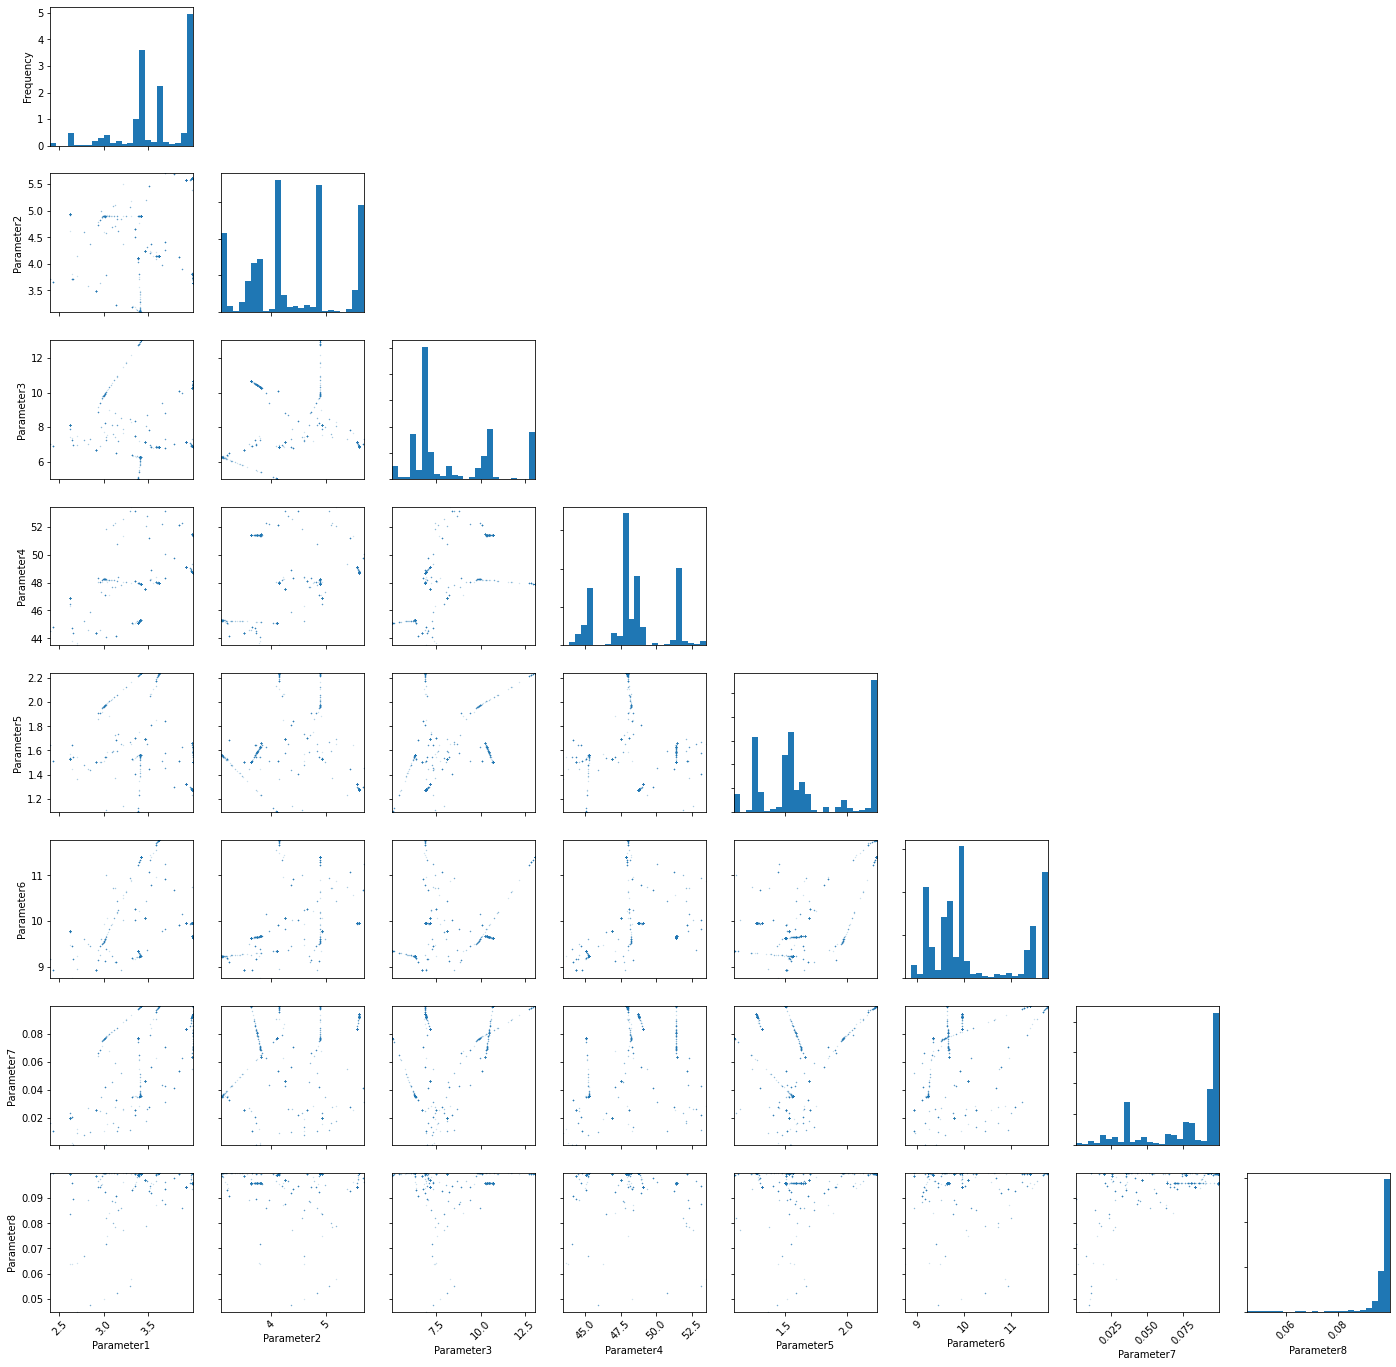

In [4]:
#%% Define loglikelihood 

class MultiGaussLogLikelihood(pints.ProblemLogLikelihood):
    '''
    Define a tailored log-Likelihood for our problem.
    '''
    def __init__(self, model, times, values, simulate_param):
        # Using sum of squares error for all values
        #
        # model: pints.ForwardModel
        # times: time series to simulate
        # values: multiple series that match model with simulate_param
        # simulate_param: parameters that correspond to each series in values
        # super(LogLikelihoodWithNoise, self).__init__()
        
        self._model = model
        self._dimension = self._model.dimension() + 1
        self._n_parameters = self._model.n_parameters() + 2
        self._times = times
        self._np = 2
        #print(str(len(values)))
        #print(str(len(simulate_param)))
        if len(values) == len(simulate_param):
            self._values = np.asarray(values)
            self._param = np.asarray(simulate_param)
        else:
            raise ValueError('Length of values must be the same as simulate_param')
        self._size = len(self._times)
        self._logn = 0.5 * self._size * np.log(2 * np.pi)

    def dimension(self):
        return self._dimension

    def __call__(self, x):

        total = 0
        noise_parameters = x[-self._np:]
        eta = np.asarray(noise_parameters[0::2])
        sigma = np.asarray(noise_parameters[1::2])

        # go through all simulation parameter (drug concentration)
        for i in range(len(self._param)):
            # simulate the model
            sim_param=self._param[i]
            drug_conc=self._param[i]
            valuesSim = np.transpose(self._model.simulate(x[:-self._np], self._times))
            valuesActual = self._values[i]

            total += \
                -self._logn - np.sum(
                    np.sum(np.log(valuesSim**eta * sigma), axis=0)
                    + 0.5 / sigma**2 * np.sum(
                        (valuesActual - valuesSim)**2
                        / valuesSim ** (2 * eta), axis=0))
            #error = np.log10(valuesSim) - np.log10(self._values[i])
            # sum of square error for corresponding values
            # total += self._logn + self._size * np.log(x[-1]) \
            #         + np.sum(error**2) / (2 * x[-1]**2)
        return total

class GaussLogLikelihood(pints.ProblemLogLikelihood):
    '''
    Define a tailored log-Likelihood for our problem.
    '''
    def __init__(self, model, times, values, simulate_param):
        # Using sum of squares error for all values
        #
        # model: pints.ForwardModel
        # times: time series to simulate
        # values: multiple series that match model with simulate_param
        # simulate_param: parameters that correspond to each series in values
        # super(LogLikelihoodWithNoise, self).__init__()
        
        self._model = model
        self._dimension = self._model.dimension() + 1
        self._n_parameters = self._model.n_parameters() + 1
        self._times = times
        #print(str(len(values)))
        #print(str(len(simulate_param)))
        if len(values) == len(simulate_param):
            self._values = np.asarray(values)
            self._param = np.asarray(simulate_param)
        else:
            raise ValueError('Length of values must be the same as simulate_param')
        self._size = len(self._times)
        self._logn = 0.5 * self._size * np.log(2 * np.pi)

    def dimension(self):
        return self._dimension

    def __call__(self, x):
        # Note x[:-1] model parameters; x[-1] is noise.
        total = 0
        # go through all simulation parameter (drug concentration)
        for i in range(len(self._param)):
            # simulate the model
            drug_conc=self._param[i]
            sim_param=self._param[i]
            
            valuesSim = np.transpose(self._model.simulate(x, self._times))
            
            error = np.log10(valuesSim) - np.log10(self._values[i])
            #error = log10(valuesSim) - log10(self._values[i])
            # sum of square error for corresponding values
            total += self._logn + self._size * np.log(x[-1]) \
                    + np.sum(error**2) / (2 * x[-1]**2)
        return -1.0 * total
#%% MCMC  on synthesized data 
Noise_sigma = 0.05
Noise_eta = 0.01
initialPoint=100 #Excessively small just so the Notebook runs faster, optimal value >10'000

# ConstantAndMultiplicativeGaussianLogLikelihood
log_likelihood = MultiGaussLogLikelihood(model, times, values, drug_conc)
#pints.MultiplicativeGaussianLogLikelihood()
# Starting point use optimised result

#true params are [2.3, 1e9, 3.2, 0.5, 3.8, 44, 0.002, 3.1, 0.3, 2.8]
log_prior = pints.UniformLogPrior([2,3,5,20,1,5,0,0] , [4,8,20,100,5,20,0.1,0.1])

log_posterior = pints.LogPosterior(log_likelihood, log_prior)


found_parameters_noise = np.array(list(found_parameters) + [Noise_eta] + [Noise_sigma])

# Choose starting points for 5 mcmc chains
xs = [
    found_parameters_noise * 1,
    found_parameters_noise * 0.9,
    found_parameters_noise * 1.05,
    found_parameters_noise * 0.95,
    found_parameters_noise * 1.1,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(500) #Excessively small just so the Notebook runs faster, optimal value >50'000

# Start adapting after 10000 iterations
mcmc.set_initial_phase_iterations(initialPoint)

mcmc.set_chain_filename('/Users/lavex/Documents/GitHub/Synth_data/notebooks_output/CompleteTK_LogCFUGaussianNoise_Chain.csv')
mcmc.set_log_pdf_filename('/Users/lavex/Documents/GitHub/Synth_data/notebooks_output/CompleteTK_LogCFUGaussianNoise_PLogPDF.csv')

print('Running...')
chains = mcmc.run()
print('Done!')
pints.plot.pairwise(np.vstack(chains), kde=False)
